<img src='../images/ga_logo_large.png' style="display: block; margin-left: auto; margin-right: auto;">

---
## **Project 4: Stocks and Portfolios**

---
### **Pre Processing and Model Training**

----
**Imports**

In [5]:
# import needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

---
**Read in Data**

In [7]:
input_path1 = '../data/clean_data/stocks-clean-data-2.csv'
input_path2 = '../data/clean_data/stock-correlations.csv'

stocks = pd.read_csv(input_path1)
stock_corrs = pd.read_csv(input_path2)

Confirm dimensionality

In [9]:
print(stocks.shape)
print('-'*15)
print(stock_corrs.shape)

(26308, 13)
---------------
(503, 5)


In [10]:
# merge one col from correlations to stock
stocks = pd.merge(stocks, stock_corrs[['symbol', 'corr_weighted_vol_vs_volatility']], on = 'symbol', how = 'left')

In [11]:
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399


----
**Missing Values and Data Types**

In [13]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26308 entries, 0 to 26307
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   trading_volume                   26308 non-null  float64
 1   weighted_volume                  26308 non-null  float64
 2   open_price                       26308 non-null  float64
 3   close_price                      26308 non-null  float64
 4   highest_price                    26308 non-null  float64
 5   lowest_price                     26308 non-null  float64
 6   timestamp                        26308 non-null  int64  
 7   transactions                     26308 non-null  int64  
 8   symbol                           26308 non-null  object 
 9   price_range                      26308 non-null  float64
 10  volatility                       26308 non-null  float64
 11  price_change_percentage          26308 non-null  float64
 12  date              

The data was previously cleaned, so everything looks good, as expected.

---
### **Model 1**

---
**Pre-processing Stage**<br>
Use all numeric features, except `corr_weighted_vol_vs_volatility`.  This will be used for evaluating the different clusters later.

In [106]:
# set a random seed for reproducibility
np.random.seed(2024)

In [108]:
# keep track of metrics for each model iteration on this list
# input format to append {k: value, n_init: value, inertia: value, silhouette: value, remarks: text}
metrics = []

Scale Features

In [111]:
# instantiate standard scaler
sc = StandardScaler()

# scale data ----------------------------------------------------------

# drop non-numeric columns from stocks df, as well as corr_weighted_vol_vs_volatility
# symbol: 503 unique values, too many to encode
# date: does not make sense to keep as
# there is already a timestamp column in ms
stocks_sc1 = sc.fit_transform(stocks.drop(columns = ['symbol', 'date', 'corr_weighted_vol_vs_volatility']))         

Build pipeline with just a KMeans model to hyper tune a couple of parameters.

In [115]:
pipe = Pipeline([
    ('km', KMeans(random_state = 2024))
])

Set parameters to search over

In [118]:
params = {
    'km__n_clusters': [*range(3, 12)],
    'km__n_init': [10, 20, 30]
}

Instantiate GridSearchCV object

In [120]:
gs1 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Determine best parameters to use to initially instantiate KMeans model

In [124]:
# fit gridsearch with all numeric columns
# except corr_weighted_vol_vs_volatility
gs1.fit(stocks.drop(columns = ['symbol', 'date', 'corr_weighted_vol_vs_volatility']))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [126]:
gs1.best_params_

{'km__n_clusters': 11, 'km__n_init': 20}

In [128]:
# fit KMeans model based on the best parameters
km1 = KMeans(
    n_clusters = gs1.best_params_['km__n_clusters'],
    n_init = gs1.best_params_['km__n_init'],
    random_state = 2024
)

km1.fit(stocks_sc1)

KMeans(n_clusters=11, n_init=20, random_state=2024)

In [130]:
# get cluster labels
set(km1.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [132]:
# check inertia score
km1.inertia_

105047.47229847322

In [134]:
# check silhouette score
silhouette_score(stocks_sc1, km1.labels_)

0.2638208186271272

In [136]:
# store results
results = {
    'clusters': gs1.best_params_['km__n_clusters'],
    'n_init': gs1.best_params_['km__n_init'],
    'inertia': round(km1.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc1, km1.labels_), 3),
    'remarks': 'Cluster A: All numeric features',
    'reference': 'stocks_sc1, gs1, km1'
}

metrics.append(results)

In [137]:
# add clusters to original dataset
stocks['cluster_a'] = km1.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility,cluster_a,cluster_b,cluster_c
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399,2,0,4
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399,10,4,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399,10,0,4
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399,10,4,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399,10,5,0


In [140]:
# check number of unique stocks per cluster
stocks.groupby('cluster_a')['symbol'].nunique()

cluster_a
0     393
1       1
2     407
3     312
4      63
5       1
6     212
7       5
8     195
9     398
10     18
Name: symbol, dtype: int64

---
### **Model 2**

---
**Pre-processing Stage**<br>
Use only the three engineered features: `price_range`, `volatility`, `price_change_percentage`.

Scale Features

In [142]:
# standard scaler is already instantiated as sc
# scale data, just three engineered features
stocks_sc2 = sc.fit_transform(stocks[['price_range', 'volatility', 'price_change_percentage']])         

The pipeline steps and parameters stay the same, only another instance of the gridsearch must be setup to search over a reduced number of features.

In [145]:
gs2 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Determine best parameters for second iteration...

In [149]:
gs2.fit(stocks[['price_range', 'volatility', 'price_change_percentage']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [151]:
gs2.best_params_

{'km__n_clusters': 11, 'km__n_init': 30}

In [153]:
# fit KMeans model based on the best parameters
km2 = KMeans(
    n_clusters = gs2.best_params_['km__n_clusters'],
    n_init = gs2.best_params_['km__n_init'],
    random_state = 2024
)

km2.fit(stocks_sc2)

KMeans(n_clusters=11, n_init=30, random_state=2024)

In [155]:
set(km2.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [157]:
km2.inertia_

12192.99107335705

In [159]:
silhouette_score(stocks_sc2, km2.labels_)

0.3766339649348925

In [161]:
# store results
results = {
    'clusters': gs2.best_params_['km__n_clusters'],
    'n_init': gs2.best_params_['km__n_init'],
    'inertia': round(km2.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc2, km2.labels_), 3),
    'remarks': 'Cluster B: Three engineered features',
    'reference': 'stocks_sc2, gs2, km2'
}

metrics.append(results)

In [162]:
# add clusters to original dataset
stocks['cluster_b'] = km2.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility,cluster_a,cluster_b,cluster_c
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399,2,3,4
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399,10,9,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399,10,3,4
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399,10,9,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399,10,8,0


In [165]:
# check number of unique stocks per cluster
stocks.groupby('cluster_b')['symbol'].nunique()

cluster_b
0     156
1      11
2     348
3     499
4       1
5      56
6       1
7     248
8     494
9     480
10      5
Name: symbol, dtype: int64

---
### **Model 3**

---
**Pre-processing Stage**<br>
Use only two strongest engineered features: `price_range` and `volatility`.

Scale features

In [167]:
# standard scaler is already instantiated as sc
# scale data, just three engineered features
stocks_sc3 = sc.fit_transform(stocks[['price_range', 'volatility']])         

Same, just instantiate new gridsearch object

In [170]:
gs3 = GridSearchCV(
    pipe,
    param_grid = params,
    n_jobs = -1,
    verbose = 1
)

---
**Modeling and Clustering**

Third iteration...

In [172]:
gs3.fit(stocks[['price_range', 'volatility']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('km', KMeans(random_state=2024))]),
             n_jobs=-1,
             param_grid={'km__n_clusters': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'km__n_init': [10, 20, 30]},
             verbose=1)

In [174]:
gs3.best_params_

{'km__n_clusters': 11, 'km__n_init': 30}

In [176]:
# fit KMeans model based on the best parameters
km3 = KMeans(
    n_clusters = gs3.best_params_['km__n_clusters'],
    n_init = gs3.best_params_['km__n_init'],
    random_state = 2024
)

km3.fit(stocks_sc3)

KMeans(n_clusters=11, n_init=30, random_state=2024)

In [178]:
set(km3.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [180]:
km3.inertia_

3287.3012373446795

In [182]:
silhouette_score(stocks_sc3, km3.labels_)

0.5334423045648305

In [184]:
# store results
results = {
    'clusters': gs3.best_params_['km__n_clusters'],
    'n_init': gs3.best_params_['km__n_init'],
    'inertia': round(km3.inertia_, 0),
    'silhouette': round(silhouette_score(stocks_sc3, km3.labels_), 3),
    'remarks': 'Cluster C: Best Two engineered features',
    'reference': 'stocks_sc3, gs3, km3'
}

metrics.append(results)

In [185]:
# add clusters to original dataset
stocks['cluster_c'] = km3.labels_

# confirm
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility,cluster_a,cluster_b,cluster_c
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399,2,3,4
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399,10,9,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399,10,3,4
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399,10,9,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399,10,8,0


In [188]:
# check number of unique stocks per cluster
stocks.groupby('cluster_c')['symbol'].nunique()

cluster_c
0     411
1       8
2       2
3     258
4     469
5      47
6       1
7       5
8       2
9     123
10      9
Name: symbol, dtype: int64

---
### **Model 4**

In [190]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 0.1 and 1.0

epsilon_values_1 = [*np.linspace(0.1, 1.0, 10)]
number_of_clusters_1 = []
number_of_outliers_1 = []
sil_scores_1 = []

for eps in epsilon_values_1:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc1)

    # count and store clusters
    number_of_clusters_1.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_1.append(round(silhouette_score(stocks_sc1, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_1.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_1}')
print(f'Outliers: {number_of_outliers_1}')
print(f'Silhouette Scores: {sil_scores_1}')

Done waiting...
Clusters: [159, 203, 123, 82, 85, 72, 74, 66, 54, 51]
Outliers: [24799, 12495, 6550, 3919, 2674, 1958, 1498, 1193, 992, 815]
Silhouette Scores: [-0.566, -0.379, -0.009, 0.192, 0.252, 0.296, 0.307, 0.311, 0.203, 0.196]


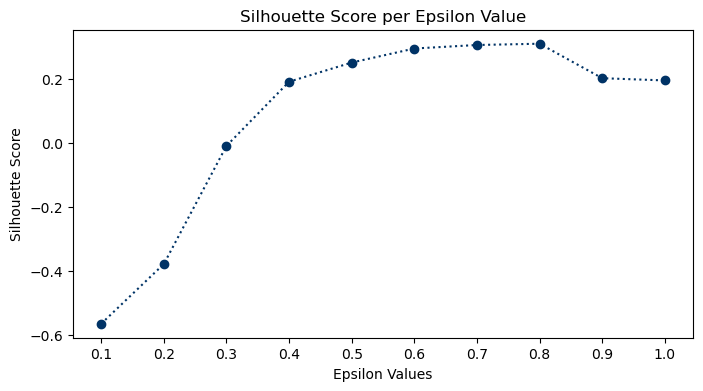

In [192]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_1, sil_scores_1, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_1)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model4a.png');

too many clusters, and low silhouette, try a higher epsilon range.

In [195]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 1.1 and 1.5

epsilon_values_2 = [*np.linspace(1.1, 1.5, 5)]
number_of_clusters_2 = []
number_of_outliers_2 = []
sil_scores_2 = []

for eps in epsilon_values_2:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc1)

    # count and store clusters
    number_of_clusters_2.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_2.append(round(silhouette_score(stocks_sc1, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_2.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_2}')
print(f'Outliers: {number_of_outliers_2}')
print(f'Silhouette Scores: {sil_scores_2}')

Done waiting...
Clusters: [36, 26, 22, 20, 13]
Outliers: [688, 622, 552, 493, 450]
Silhouette Scores: [0.198, 0.134, 0.153, 0.159, 0.189]


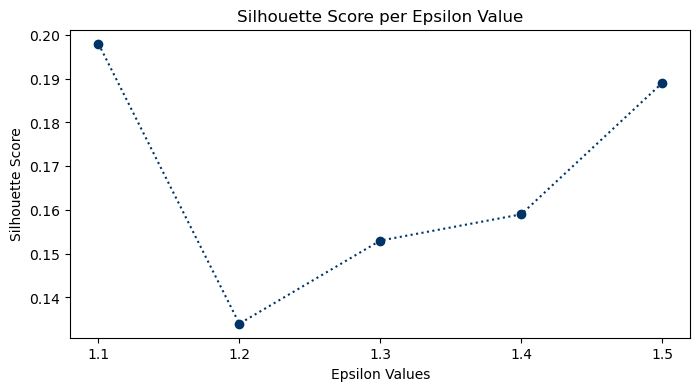

In [197]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_2, sil_scores_2, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_2)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model4b.png');

Check unique stock count for 13 clusters (epsilon 1.5)

In [200]:
dbs1 = DBSCAN(eps = 1.5)
dbs1.fit(stocks_sc1)

DBSCAN(eps=1.5)

In [202]:
set(dbs1.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [204]:
# store results
results = {
    'clusters': len(set(dbs1.labels_)),
    'n_init': np.nan,
    'inertia': np.nan,
    'silhouette': round(silhouette_score(stocks_sc1, dbs1.labels_), 3),
    'remarks': 'Cluster D: All numeric features',
    'reference': 'stocks_sc1, dbs1'
}

metrics.append(results)

In [206]:
stocks['cluster_d'] = dbs1.labels_

In [208]:
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility,cluster_a,cluster_b,cluster_c,cluster_d
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399,2,3,4,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399,10,9,0,1
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399,10,3,4,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399,10,9,0,1
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399,10,8,0,1


In [210]:
# check number of unique stocks per cluster
stocks.groupby('cluster_d')['symbol'].nunique()

cluster_d
-1      60
 0     469
 1     406
 2       1
 3     246
 4      97
 5      81
 6       3
 7      83
 8      15
 9       2
 10      2
 11      3
Name: symbol, dtype: int64

---
### **Model 5**

In [212]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 0.1 and 1.0

epsilon_values_3 = [*np.linspace(0.1, 1.0, 10)]
number_of_clusters_3 = []
number_of_outliers_3 = []
sil_scores_3 = []

for eps in epsilon_values_3:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc2)

    # count and store clusters
    number_of_clusters_3.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_3.append(round(silhouette_score(stocks_sc2, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_3.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_3}')
print(f'Outliers: {number_of_outliers_3}')
print(f'Silhouette Scores: {sil_scores_3}')

Done waiting...
Clusters: [32, 22, 14, 9, 7, 6, 4, 6, 6, 6]
Outliers: [2038, 813, 492, 355, 263, 215, 200, 163, 133, 115]
Silhouette Scores: [0.082, 0.388, 0.47, 0.615, 0.683, 0.723, 0.754, 0.748, 0.79, 0.842]


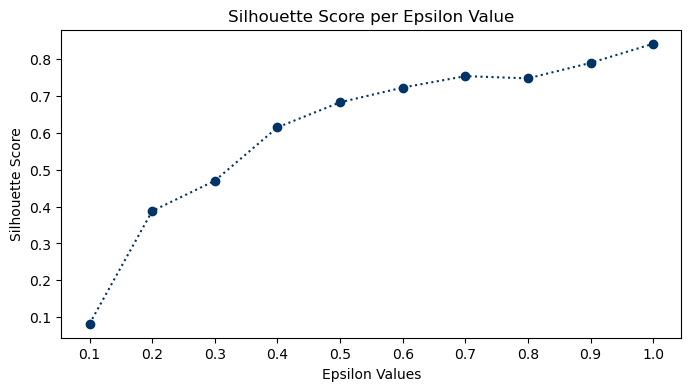

In [214]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_3, sil_scores_3, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_3)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model5.png');

Check unique stock count for 6 clusters (epsilon 1.0)

In [229]:
dbs2 = DBSCAN(eps = 1.0)
dbs2.fit(stocks_sc2)

DBSCAN(eps=1.0)

In [233]:
set(dbs2.labels_)

{-1, 0, 1, 2, 3, 4}

In [235]:
# store results
results = {
    'clusters': len(set(dbs2.labels_)),
    'n_init': np.nan,
    'inertia': np.nan,
    'silhouette': round(silhouette_score(stocks_sc2, dbs2.labels_), 3),
    'remarks': 'Cluster E: Three engineered features',
    'reference': 'stocks_sc2, dbs2'
}

metrics.append(results)

In [236]:
stocks['cluster_e'] = dbs2.labels_
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility,cluster_a,cluster_b,cluster_c,cluster_d,cluster_e
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399,2,3,4,0,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399,10,9,0,1,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399,10,3,4,0,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399,10,9,0,1,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399,10,8,0,1,0


In [239]:
# check number of unique stocks per cluster
stocks.groupby('cluster_e')['symbol'].nunique()

cluster_e
-1     27
 0    503
 1      3
 2      2
 3      5
 4      1
Name: symbol, dtype: int64

---
### **Model 6**

In [241]:
# loop thru various epsilon values to see how clusters change, and to reduce outliers
# default value for epsilon is 0.5, test values between 0.1 and 1.0

epsilon_values_4 = [*np.linspace(0.1, 1.0, 10)]
number_of_clusters_4 = []
number_of_outliers_4 = []
sil_scores_4 = []

for eps in epsilon_values_4:
    
    # instantiate model
    dbscan = DBSCAN(eps = eps)
    
    # fit model
    dbscan.fit(stocks_sc3)

    # count and store clusters
    number_of_clusters_4.append(len(set(dbscan.labels_)))

    # calculate and store silhouette score
    sil_scores_4.append(round(silhouette_score(stocks_sc3, dbscan.labels_), 3))
    
    # check and count outliers
    if -1 in set(dbscan.labels_):
        number_of_outliers_4.append((dbscan.labels_ == -1).sum())

print('Done waiting...')
print(f'Clusters: {number_of_clusters_4}')
print(f'Outliers: {number_of_outliers_4}')
print(f'Silhouette Scores: {sil_scores_4}')

Done waiting...
Clusters: [11, 4, 6, 7, 4, 6, 5, 5, 5, 4]
Outliers: [463, 253, 197, 152, 139, 109, 93, 75, 65, 61]
Silhouette Scores: [0.676, 0.827, 0.797, 0.831, 0.881, 0.86, 0.921, 0.928, 0.927, 0.927]


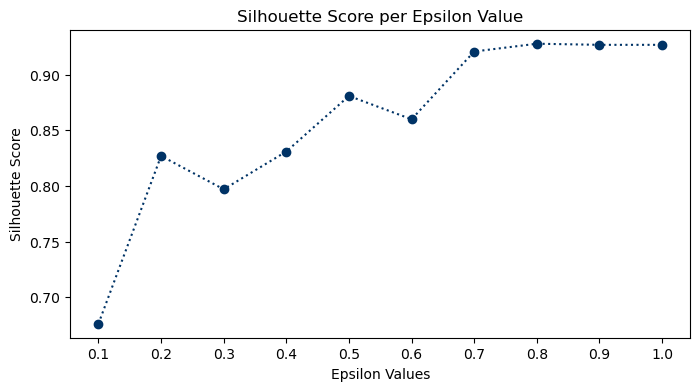

In [243]:
# check silhouette scores vs. epsilon

plt.figure(figsize = (8, 4))

plt.plot(epsilon_values_4, sil_scores_4, color = '#003366', marker = 'o', linestyle = ':')

plt.xticks(epsilon_values_4)
plt.xlabel('Epsilon Values')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Epsilon Value');

plt.savefig('../images/silhouette_model6.png');

Check unique stock count for 7 clusters (epsilon 0.4)

In [245]:
dbs3 = DBSCAN(eps = 0.4)
dbs3.fit(stocks_sc3)

DBSCAN(eps=0.4)

In [247]:
set(dbs3.labels_)

{-1, 0, 1, 2, 3, 4, 5}

In [259]:
# store results
results = {
    'clusters': len(set(dbs3.labels_)),
    'n_init': np.nan,
    'inertia': np.nan,
    'silhouette': round(silhouette_score(stocks_sc3, dbs3.labels_), 3),
    'remarks': 'Cluster F: Two engineered features',
    'reference': 'stocks_sc3, dbs3'
}

metrics.append(results)

In [253]:
stocks['cluster_f'] = dbs3.labels_
stocks.head()

,trading_volume,weighted_volume,open_price,close_price,highest_price,lowest_price,timestamp,transactions,symbol,price_range,volatility,price_change_percentage,date,corr_weighted_vol_vs_volatility,cluster_a,cluster_b,cluster_c,cluster_d,cluster_e,cluster_f
0,119605127.0,233.6043,234.45,230.76,236.85,227.76,1729396800000,1743438,AAPL,9.09,3.69,-1.573896,2024-10-20,0.095399,2,3,4,0,0,0
1,358320463.0,230.2414,224.50,235.00,237.49,221.33,1728187200000,5563002,AAPL,16.16,10.50,4.677060,2024-10-06,0.095399,10,9,0,1,0,0
2,411269719.0,227.1824,227.34,226.80,233.00,223.02,1726977600000,5835500,AAPL,9.98,0.54,-0.237530,2024-09-22,0.095399,10,3,4,0,0,0
3,737776128.0,223.8730,220.82,228.20,233.09,213.92,1725768000000,7473637,AAPL,19.17,7.38,3.342089,2024-09-08,0.095399,10,9,0,1,0,0
4,374000504.0,225.6062,226.76,220.82,232.92,217.48,1724558400000,5682718,AAPL,15.44,5.94,-2.619510,2024-08-25,0.095399,10,8,0,1,0,0


In [255]:
# check number of unique stocks per cluster
stocks.groupby('cluster_f')['symbol'].nunique()

cluster_f
-1     10
 0    502
 1      3
 2      6
 3      2
 4      4
 5      3
Name: symbol, dtype: int64

In [260]:
pd.DataFrame(metrics)

,clusters,n_init,inertia,silhouette,remarks,reference
0,11,20.0,105047.0,0.264,Cluster A: All numeric features,"stocks_sc1, gs1, km1"
1,11,30.0,12193.0,0.377,Cluster B: Three engineered features,"stocks_sc2, gs2, km2"
2,11,30.0,3287.0,0.533,Cluster C: Best Two engineered features,"stocks_sc3, gs3, km3"
3,13,NaN,NaN,0.189,Cluster D: All numeric features,"stocks_sc1, dbs1"
4,6,NaN,NaN,0.842,Cluster E: Three engineered features,"stocks_sc2, dbs2"
5,7,NaN,NaN,0.831,Cluster F: Two engineered features,"stocks_sc3, dbs3"


In [283]:
stocks['volatility'].describe()

count    26308.000000
mean         7.040720
std         18.359439
min          0.000000
25%          1.171500
50%          3.030000
75%          7.191250
max        821.270000
Name: volatility, dtype: float64

In [289]:
stocks['volatility'].describe(percentiles = [.33, .66])

count    26308.000000
mean         7.040720
std         18.359439
min          0.000000
33%          1.648620
50%          3.030000
66%          5.140000
max        821.270000
Name: volatility, dtype: float64

In [285]:
stocks.groupby('symbol')['volatility'].mean()

symbol
A        5.029434
AAPL     6.755717
ABBV     4.863962
ABNB     8.406849
ABT      3.112170
          ...    
XYL      4.297736
YUM      3.028208
ZBH      4.115094
ZBRA    14.621132
ZTS      6.502075
Name: volatility, Length: 503, dtype: float64

In [281]:
stock_corrs

,symbol,corr_weighted_vol_vs_volatility,corr_weighted_vol_vs_price_range,corr_price_range_vs_volatility,avg_pct_change
0,A,0.196730,0.134928,0.887184,0.191745
1,AAPL,0.095399,0.167993,0.653506,1.137613
2,ABBV,-0.088356,0.007686,0.820537,0.550293
3,ABNB,-0.081729,-0.117606,0.779417,0.654050
4,ABT,0.120794,-0.102955,0.690813,0.619345
...,...,...,...,...,...
498,XYL,0.003643,-0.026416,0.852032,0.808240
499,YUM,-0.191420,-0.109960,0.755490,0.495102
500,ZBH,0.009146,0.098228,0.772789,0.086624
501,ZBRA,-0.047176,-0.039267,0.664490,0.910028
